# \[STBDA\] 14wk: GAN

김보람  
2023-07-28

> 해당 강의노트는 전북대학교 최규빈교수님
> [STBDA2022](https://guebin.github.io/STBDA2022/) 자료임

### GAN (Generative Adversarial Network)

`-` 저자: 이안굿펠로우 (이름이 특이함. 좋은친구..) - 제가 추천한 딥러닝
교재의 저자 - 천재임 - 지도교수가 요수아 벤지오

`-` 논문 NIPS, 저는 이 논문 읽고 소름돋았어요.. -
https://arxiv.org/abs/1406.2661 (현재시점, 38751회 인용되었음)

`-` 최근 10년간 머신러닝 분야에서 가장 혁신적인 아이디어이다. (얀르쿤,
2014년 시점..)

`-` 무슨내용? 생성모형

#### 생성모형이란? (쉬운 설명)

> 만들수 없다면 이해하지 못한 것이다, 리처드 파인만 (천재 물리학자)

`-` 사진속에 들어있는 동물이 개인지 고양이인지 맞출수 있는 기계와 개와
고양이를 그릴수 있는 기계중 어떤것이 더 시각적보에 대한 이해가 깊다고
볼수 있는가?

`-` 진정으로 인공지능이 이미지를 이해했다면, 이미지를 만들수도 있어야
한다. $\to$ 이미지를 생성하는 모형을 만들어보자 $\to$ 성공

![](https://upload.wikimedia.org/wikipedia/commons/1/1f/Woman_1.jpg)

#### GAN의 응용분야

`-` 내가 찍은 사진이 피카소의 화풍으로 표현된다면? -
https://www.lgsl.kr/sto/stories/60/ALMA2020070001

`-` 퀸의 라이브에이드가 4k로 나온다면?

`-` 1920년대 서울의 모습이 칼라로 복원된다면?

`-` 딥페이크: 유명인의 가짜 포르노, 가짜뉴스, 협박(거짓기소)

`-` 게임영상 (파이널판타지)

`-` 거북이의 커버..

`-` 너무 많아요…..

#### 생성모형이란? 통계학과 버전의 설명

> 제한된 정보만으로 어떤 문제를 풀 떄, 그 과정에서 원래의 문제보다
> 일반적인 문제를 풀지 말고, 가능한 원래의 문제를 직접 풀어야한다.
> 배프닉 (SVM 창시자)

`-` 이미지 $\boldsymbol{x}$가 주어졌을 경우 라벨을 $y$라고 하자.

`-` 이미지를 보고 라벨을 맞추는 일은 $p(y| \boldsymbol{x})$에 관심이
있다.

`-` 이미지를 생성하는 일은 $p(\boldsymbol{x},y)$에 관심이 있는것이다.

`-` 데이터의 생성확률 $p(\boldsymbol{x},y)$을 알면 클래스의 사후확률
$p(y|\boldsymbol{x})$를 알 수 있음. (아래의 수식 참고) 하지만 역은
불가능

$$p(y|x) = \frac{p(x,y)}{p(x)} = \frac{p(x,y)}{\sum_{y}p(x,y)} $$

-   즉 이미지를 생성하는일은 분류문제보다 더 어려운 일이라 해석가능

`-` 따라서 배프닉의 원리에 의하면 식별적 분류가 생성적 분류보다 바람직한
접근법이라 할 수 있음.

`-` 하지만 다양한 현실문제에서 생성모형이 유용할떄가 많다.

### GAN의 원리

`-` GAN은 생성모형중 하나임

`-` GAN의 원리는 경찰과 위조지폐범이 서로 선의의(?) 경쟁을 통하여 서로
발전하는 모형으로 설명할 수 있다.

> The generative model can be thought of as analogous to a team of
> counterfeiters, trying to produce fake currency and use it without
> detection, while the discriminative model is analogous to the police,
> trying to detect the counterfeit currency. Competition in this game
> drives both teams to improve their methods until the counterfeits are
> indistiguishable from the genuine articles.

`-` 서로 적대적인(adversarial) 네트워크(network)를 동시에 학습시켜
가짜이미지를 만든다(generate)

`-` 무식한 상황극..

-   위조범: 가짜돈을 만들어서 부자가 되어야지! (가짜돈을 그림)
-   경찰: (위조범이 만든 돈을 보고) 이건 가짜다!
-   위조범: 걸렸군.. 더 정교하게 만들어야지..
-   경찰: 이건 진짠가?… –\> 상사에게 혼남. 그것도 구분못하냐고
-   위조범: 더 정교하게 만들자..
-   경찰: 더 판별능력을 업그레이드 하자!
-   반복..

`-` 굉장히 우수한 경찰조차도 진짜와 가짜를 구분하지 못할때(=진짜
이미지를 0.5의 확률로만 진짜라고 말할때 = 가짜 이미지를 0.5의 확률로만
가짜라고 말할때) 학습을 멈춘다.

### 구현

`-` 목표: 노이즈에서 mnist자료의 이미지를 생성하여 보자.

#### import

In [1]:
import tensorflow as tf  
import tensorflow.experimental.numpy as tnp
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [2]:
tnp.experimental_enable_numpy_behavior()

#### 데이터

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [4]:
Xreal = x_train.reshape(-1,784)/255

#### 위조지폐범의 설계: noise -\> 가짜이미지를 만들어내는 네트워크를 만들자.

`-` 네트워크의 입력: 적당한 벡터 혹은 매트릭스에 노이즈 (랜덤으로 생성한
어떠한 숫자) 를 채운 것

`-` 네트워크의 출력: (28,28) shape의 매트릭스 혹은 784개의 원소를 가지는
벡터

In [5]:
net_counterfeiter= tf.keras.Sequential()
net_counterfeiter.add(tf.keras.layers.Dense(256,activation='relu'))
net_counterfeiter.add(tf.keras.layers.Dense(512,activation='relu'))
net_counterfeiter.add(tf.keras.layers.Dense(1024,activation='relu'))
net_counterfeiter.add(tf.keras.layers.Dense(784))

2022-06-09 12:43:21.685836: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero

#### 경찰의 설계: 진짜이미지는 1, 가짜이미지는 0으로 판별하는 DNN을 만들자.

`-` 네트워크의 입력? - X: (28,28) shape의 matrix 혹은 784개의 원소를
가지는 벡터

`-` 네트워크의 출력? yhat - yhat은 진짜이미지일수록1, 가짜이미지일수록
0이 되어야 한다. (왜냐하면 y가 진짜이미지이면 1, 가짜이미지이면 0
이므로)

In [6]:
net_police = tf.keras.Sequential()
net_police.add(tf.keras.layers.Dense(1024,activation='relu'))
net_police.add(tf.keras.layers.Dropout(0.3))
net_police.add(tf.keras.layers.Dense(512,activation='relu'))
net_police.add(tf.keras.layers.Dropout(0.3))
net_police.add(tf.keras.layers.Dense(256,activation='relu'))
net_police.add(tf.keras.layers.Dropout(0.3))               
net_police.add(tf.keras.layers.Dense(1,activation='sigmoid'))

#### 일단 스토리를 계속 진행해보겠습니다.

`-` 진짜 이미지가 아래와 같이 있다.

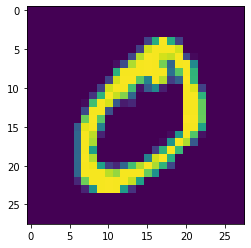

In [7]:
plt.imshow(Xreal[1].reshape(28,28))

`-` 이 이미지를 경찰이 봤습니다 -\> yhat이 나와야 하고, yhat $\approx$ 1
이어야 한다. (왜? 진짜 이미지니까)

In [8]:
policehat_from_realimage = net_police(Xreal)
policehat_from_realimage

-   진짜 이미지이므로 위의 값들이 모두 1이어야함. 즉 yhat $\approx$ 1
    이어야 좋은 것임
-   하지만 그렇지 못함 (배운것이 없는 무능한 경찰)

`-` 이번에는 가짜 이미지를 경찰이 봤다고 생각하자.

(step1) 랜덤으로 아무숫자나 생성한다.

In [9]:
Noise1=tnp.random.randn(10).reshape(1,10)

(step2) 위조범을 시켜서 이미지를 생성시킨다.

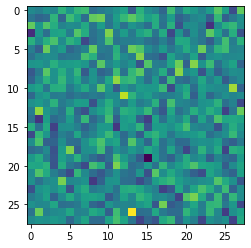

In [10]:
Xfake1 = net_counterfeiter(Noise1)
plt.imshow(Xfake1.reshape(28,28))

(step3) 위조범이 생성한 이미지를 경찰한테 넘겨본다.

In [11]:
policehat_from_Xfake1 = net_police(Xfake1)
policehat_from_Xfake1

`-` 경찰의 실력도 형편없고 위조범의 실력도 형편없다.

### 경찰네트워크의 실력을 향상하자

`-` 데이터정리 - 원래 n=60000개의 real image가 있음. 이 자료중 일부를
batch_size=500 만큼 뽑아 이것을 ${\bf X}_{batch}$라고 하자. 따라서
${\bf X}_{batch}$의 차원은 (500,784) 이다. - 위조범이 만든 가짜자료를
원래자료의 batch_size와 같은 숫자인 500만큼 만듬. 그리고 이것을
${\bf \tilde X}_{batch}$라고 하자. 그러면 ${\bf \tilde X}_{batch}$의
차원은 (500,784)이다. - 진짜자료는 1, 가짜자료는 0으로 라벨링

In [12]:
batch_size = 500

In [13]:
Noise_batch = np.random.normal(0,1,size=(batch_size,10))
Xfake_batch = net_counterfeiter(Noise_batch)

In [14]:
Xreal_batch = Xreal[:batch_size]
Xpolice_batch = tf.concat([Xreal_batch,Xfake_batch],axis=0)

In [15]:
ypolice_batch = np.zeros(2*batch_size) 
ypolice_batch[:batch_size] = 1

`-` 학습전: yhat(경찰의 예측)을 관찰

In [16]:
net_police(Xreal_batch)[:5]

In [17]:
net_police(Xfake_batch)[:5]

`-` 학습하자: compile and fit

In [18]:
net_police.compile(loss=tf.losses.binary_crossentropy, optimizer='adam') 

In [19]:
net_police.fit(Xpolice_batch,ypolice_batch)

32/32 [==============================] - 0s 1ms/step - loss: 0.0591

`-` 훈련된 경찰의 성능을 살펴보자.

In [20]:
net_police(Xreal_batch)[:5]

In [21]:
net_police(Xfake_batch)[:5]

### 위조범네트워크의 성능을 향상시키자.

`-` 자료구조: 네트워크의 입력은 임의의 노이즈, 네트워크의 출력은
fakeimage

`-` 손실함수의 설계? - 위조범 네트워크의 출력은 fakeimage, 위조범
네트워크의 yhat은 fakeimage 이다! - 이 가짜이미지를 (위조범네트워크의
yhat을) 경찰이 진짜라고 판단해야 위조범 입장에서는 좋은것. 즉
“경찰네트워크(위조범네트워크의yhat) $\approx$ 1” 이어야 함

In [22]:
def loss_counterfeiter(y,yhat): 
    # note that yhat is fake image! 
    return tf.losses.binary_crossentropy(y,net_police(yhat)) # here label should be 1 

In [23]:
ycounterfeiter_batch = np.ones(batch_size) 
net_counterfeiter.compile(loss=loss_counterfeiter,optimizer = 'adam')

In [24]:
net_counterfeiter.fit(Noise_batch, ycounterfeiter_batch)

16/16 [==============================] - 0s 1ms/step - loss: 2.0207

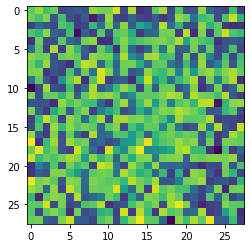

In [25]:
plt.imshow(net_counterfeiter(Noise1).reshape(28,28))

-   학습된 이미지의 하나의 샘플 (아직 노이즈같음)

In [26]:
net_police(net_counterfeiter(Noise_batch))[:5]

-   노이즈같지만 아무튼 이정도로도 경찰은 속는다!

### 두 적대적 네트워크를 경쟁시키자.

In [34]:
for _ in tqdm(range(500)):
    # step1: 가짜이미지 생성, 데이터정리 
    Noise_batch = np.random.normal(0,1,size=(batch_size,10))
    Xfake_batch = net_counterfeiter(Noise_batch)
    Xreal_batch = Xreal[np.random.randint(0,Xreal.shape[0],size=batch_size)]
    
    # step2: 경찰네트워크용 데이터 정리 
    Xpolice_batch = tf.concat([Xreal_batch,Xfake_batch],axis=0)
    ypolice_batch = np.zeros(2*batch_size)
    ypolice_batch[:batch_size] = 1 
    
    # step3: 경찰네트워크 훈련
    net_police.fit(Xpolice_batch,ypolice_batch,verbose=0) 
    
    # step4: 위조범네트워크 훈련 
    Xcounterfeiter_batch = Noise_batch # <- 위조범 네트워크의 X 
    ycounterfeiter_batch = np.ones(batch_size) # <- 위조범네트워크의 y 
    net_counterfeiter.fit(Noise_batch, ycounterfeiter_batch, verbose=0) 


100%|██████████| 500/500 [00:48<00:00, 10.25it/s]

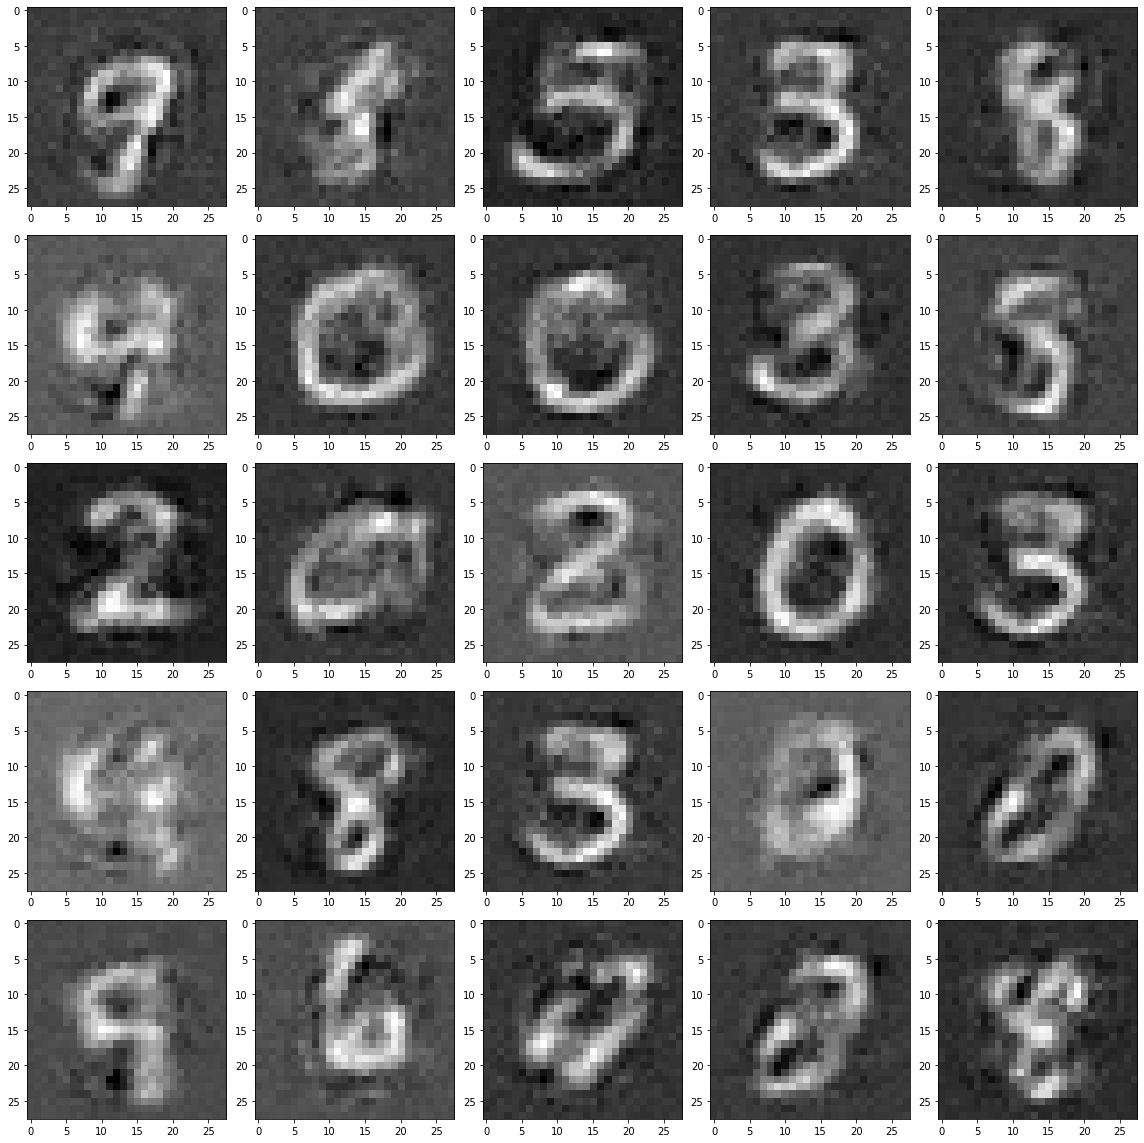

In [35]:
fig, ax = plt.subplots(5,5)
k=0
for i in range(5):
    for j in range(5): 
        ax[i][j].imshow(net_counterfeiter.predict(Noise_batch)[k].reshape(28,28),cmap='gray')
        k=k+1
fig.set_figwidth(16)
fig.set_figheight(16)
fig.tight_layout()